# Install Packages

In [1]:
!pip uninstall -y tensorflow
!pip install tensorflow-gpu==1.13.1
!pip install keras==2.2.4
!pip install git+https://www.github.com/keras-team/keras-contrib.git
!pip install plot_keras_history

Found existing installation: tensorflow 2.7.0
Uninstalling tensorflow-2.7.0:
  Successfully uninstalled tensorflow-2.7.0
     |████████████████████████████████| 345.0 MB 4.1 kB/s 
     |████████████████████████████████| 50 kB 6.4 MB/s 
     |████████████████████████████████| 367 kB 31.0 MB/s 
     |████████████████████████████████| 3.2 MB 42.2 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.7.0
    Uninstalling tensorflow-estimator-2.7.0:
      Successfully uninstalled tensorflow-estimator-2.7.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.7.0
    Uninstalling tensorboard-2.7.0:
      Successfully uninstalled tensorboard-2.7.0
     |████████████████████████████████| 312 kB 5.3 MB/s 
  Attempting uninstall: keras
    Found existing installation: keras 2.7.0
    Uninstalling keras-2.7.0:
      Successfully uninstalled keras-2.7.0
  Cloning https://www.github.com/keras-team/keras-contrib.git t

# Imports for rest of the notebook

In [2]:
import pickle
import operator
import re
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from plot_keras_history import plot_history
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix
from keras_contrib.utils import save_load_utils

from keras import layers
from keras import optimizers

from keras.models import Model
from keras.models import Input

from keras_contrib.layers import CRF
# from tensorflow_addons.layers import CRF
from keras_contrib import losses
from keras_contrib import metrics
from tensorflow import keras

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

# Load Data 

In [3]:
data_df = pd.read_csv("/content/drive/MyDrive/CS-583-Bert-Named-Entity /ner_dataset.csv", encoding="iso-8859-1", header=0)
data_df.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


# Data Exploration 

In [4]:
data_df = data_df.fillna(method="ffill")
data_df["Sentence #"] = data_df["Sentence #"].apply(lambda s: s[9:])
data_df["Sentence #"] = data_df["Sentence #"].astype("int32")
data_df.head()

,Sentence #,Word,POS,Tag
0,1,Thousands,NNS,O
1,1,of,IN,O
2,1,demonstrators,NNS,O
3,1,have,VBP,O
4,1,marched,VBN,O


In [5]:
print("Total number of sentences in the dataset: {:,}".format(data_df["Sentence #"].nunique()))
print("Total words in the dataset: {:,}".format(data_df.shape[0]))

Total number of sentences in the dataset: 47,959
Total words in the dataset: 1,048,575


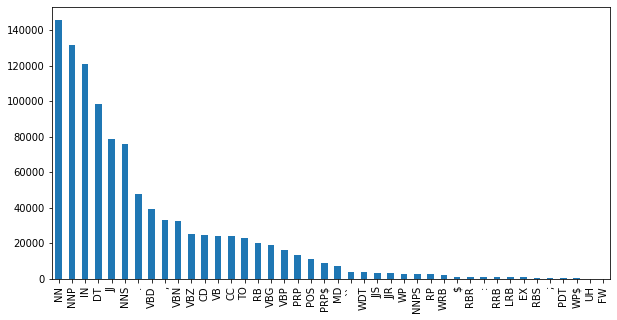

In [6]:
data_df["POS"].value_counts().plot(kind="bar", figsize=(10,5));

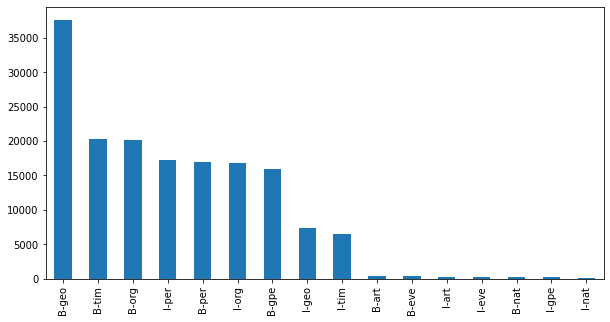

In [7]:
data_df[data_df["Tag"]!="O"]["Tag"].value_counts().plot(kind="bar", figsize=(10,5))

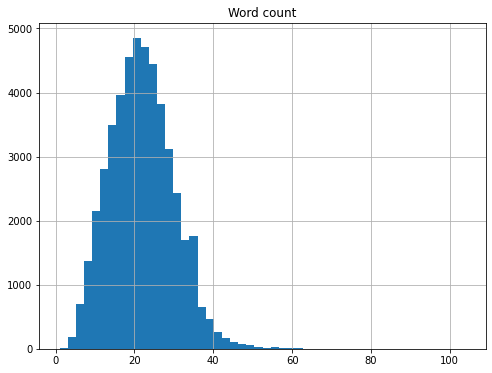

In [8]:
word_counts = data_df.groupby("Sentence #")["Word"].agg(["count"])
word_counts = word_counts.rename(columns={"count": "Word count"})
word_counts.hist(bins=50, figsize=(8,6));

In [9]:
MAX_SENTENCE = word_counts.max()[0]
print("Longest sentence in the corpus contains {} words.".format(MAX_SENTENCE))

Longest sentence in the corpus contains 104 words.


In [10]:
longest_sentence_id = word_counts[word_counts["Word count"]==MAX_SENTENCE].index[0]
print("ID of the longest sentence is {}.".format(longest_sentence_id))
longest_sentence = data_df[data_df["Sentence #"]==longest_sentence_id]["Word"].str.cat(sep=' ')
print("The longest sentence in the corpus is:\n")
print(longest_sentence)

ID of the longest sentence is 22480.
The longest sentence in the corpus is:

Fisheries in 2006 - 7 landed 1,26,976 metric tons , of which 82 % ( 1,04,586 tons ) was krill ( Euphausia superba ) and 9.5 % ( 12,027 tons ) Patagonian toothfish ( Dissostichus eleginoides - also known as Chilean sea bass ) , compared to 1,27,910 tons in 2005 - 6 of which 83 % ( 1,06,591 tons ) was krill and 9.7 % ( 12,396 tons ) Patagonian toothfish ( estimated fishing from the area covered by the Convention of the Conservation of Antarctic Marine Living Resources ( CCAMLR ) , which extends slightly beyond the Southern Ocean area ) .


# Creating Word2Index and Usable Dataset

In [11]:
all_words = list(set(data_df["Word"].values))
all_tags = list(set(data_df["Tag"].values))

print("Number of unique words: {}".format(data_df["Word"].nunique()))
print("Number of unique tags : {}".format(data_df["Tag"].nunique()))

Number of unique words: 35178
Number of unique tags : 17


In [12]:
word2index = {word: idx + 2 for idx, word in enumerate(all_words)}
word2index["--UNKNOWN_WORD--"]=0
word2index["--PADDING--"]=1
index2word = {idx: word for word, idx in word2index.items()}

In [13]:
for k,v in sorted(word2index.items(), key=operator.itemgetter(1))[:10]:
    print(k,v)

--UNKNOWN_WORD-- 0
--PADDING-- 1
counter-terrorism 2
Pro-Russian 3
refinancing 4
Patron 5
Arbab 6
exploitation 7
sum 8
Dandy 9


In [14]:
test_word = "India"

test_word_idx = word2index[test_word]
test_word_lookup = index2word[test_word_idx]

print("The index of the word {} is {}.".format(test_word, test_word_idx))
print("The word with index {} is {}.".format(test_word_idx, test_word_lookup))

The index of the word India is 11487.
The word with index 11487 is India.


In [15]:
tag2index = {tag: idx + 1 for idx, tag in enumerate(all_tags)}
tag2index["--PADDING--"] = 0

index2tag = {idx: word for word, idx in tag2index.items()}

In [16]:
def to_tuples(data):
    iterator = zip(data["Word"].values.tolist(),
                   data["POS"].values.tolist(),
                   data["Tag"].values.tolist())
    return [(word, pos, tag) for word, pos, tag in iterator]

sentences = data_df.groupby("Sentence #").apply(to_tuples).tolist()

print(sentences[0])

[('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-gpe'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O')]


In [17]:
X = [[word[0] for word in sentence] for sentence in sentences]
y = [[word[2] for word in sentence] for sentence in sentences]
print("X[0]:", X[0])
print("y[0]:", y[0])

X[0]: ['Thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'London', 'to', 'protest', 'the', 'war', 'in', 'Iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'British', 'troops', 'from', 'that', 'country', '.']
y[0]: ['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']


In [18]:
X = [[word2index[word] for word in sentence] for sentence in X]
y = [[tag2index[tag] for tag in sentence] for sentence in y]
print("X[0]:", X[0])
print("y[0]:", y[0])

X[0]: [12062, 13511, 24388, 4848, 5510, 13100, 22329, 21519, 18610, 11214, 29473, 18671, 25707, 3314, 11304, 11214, 22871, 13511, 29249, 13824, 16539, 21720, 28177, 13266]
y[0]: [9, 9, 9, 9, 9, 9, 4, 9, 9, 9, 9, 9, 4, 9, 9, 9, 9, 9, 16, 9, 9, 9, 9, 9]


In [19]:
X = [sentence + [word2index["--PADDING--"]] * (MAX_SENTENCE - len(sentence)) for sentence in X]
y = [sentence + [tag2index["--PADDING--"]] * (MAX_SENTENCE - len(sentence)) for sentence in y]
print("X[0]:", X[0])
print("y[0]:", y[0])

X[0]: [12062, 13511, 24388, 4848, 5510, 13100, 22329, 21519, 18610, 11214, 29473, 18671, 25707, 3314, 11304, 11214, 22871, 13511, 29249, 13824, 16539, 21720, 28177, 13266, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
y[0]: [9, 9, 9, 9, 9, 9, 4, 9, 9, 9, 9, 9, 4, 9, 9, 9, 9, 9, 16, 9, 9, 9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [20]:
TAG_COUNT = len(tag2index)
y = [ np.eye(TAG_COUNT)[sentence] for sentence in y]
print("X[0]:", X[0])
print("y[0]:", y[0])

X[0]: [12062, 13511, 24388, 4848, 5510, 13100, 22329, 21519, 18610, 11214, 29473, 18671, 25707, 3314, 11304, 11214, 22871, 13511, 29249, 13824, 16539, 21720, 28177, 13266, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
y[0]: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


# Test and Train Split

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1234)

print("Number of sentences in the training dataset: {}".format(len(X_train)))
print("Number of sentences in the test dataset : {}".format(len(X_test)))

Number of sentences in the training dataset: 43163
Number of sentences in the test dataset : 4796


In [22]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

# Define Model 

In [23]:
WORD_COUNT = len(index2word)
DENSE_EMBEDDING = 50
LSTM_UNITS = 50
LSTM_DROPOUT = 0.1
DENSE_UNITS = 100
BATCH_SIZE = 256
MAX_EPOCHS = 5

In [24]:
input_layer = layers.Input(shape=(MAX_SENTENCE,))

model = layers.Embedding(WORD_COUNT, DENSE_EMBEDDING, embeddings_initializer="uniform", input_length=MAX_SENTENCE)(input_layer)
model = layers.Bidirectional(layers.LSTM(LSTM_UNITS, recurrent_dropout=LSTM_DROPOUT, return_sequences=True))(model)

model = layers.TimeDistributed(layers.Dense(DENSE_UNITS, activation="relu"))(model)

crf_layer = CRF(units=TAG_COUNT)
# CRF_LAYER = tf.keras.layers.CRF((TAG_COUNT))
output_layer = crf_layer(model)

ner_model = Model(input_layer, output_layer)

loss = losses.crf_loss
acc_metric = metrics.crf_accuracy
opt = optimizers.Adam(lr=0.001)
# opt= keras.optimizers.Adam(lr=0.0005)

ner_model.compile(optimizer=opt, loss=loss, metrics=[acc_metric])

ner_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 104)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 104, 50)           1759000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 104, 100)          40400     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 104, 100)          10100     
_________________________________________________________________
crf_1 (CRF)                  (None, 104, 18)           2178      
Total params: 1,811,678
Trainable params: 1,811,678
Non-trainable params: 0
___________

# Run with 10% Validation Split

In [25]:
history = ner_model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=MAX_EPOCHS, validation_split=0.1, verbose=2)

Instructions for updating:
Use tf.cast instead.
Train on 38846 samples, validate on 4317 samples
Epoch 1/5
 - 93s - loss: 0.5031 - crf_accuracy: 0.8719 - val_loss: 0.1498 - val_crf_accuracy: 0.9672
Epoch 2/5
 - 89s - loss: 0.1119 - crf_accuracy: 0.9696 - val_loss: 0.0743 - val_crf_accuracy: 0.9756
Epoch 3/5
 - 90s - loss: 0.0625 - crf_accuracy: 0.9803 - val_loss: 0.0524 - val_crf_accuracy: 0.9845
Epoch 4/5
 - 90s - loss: 0.0404 - crf_accuracy: 0.9890 - val_loss: 0.0357 - val_crf_accuracy: 0.9899
Epoch 5/5
 - 90s - loss: 0.0280 - crf_accuracy: 0.9922 - val_loss: 0.0286 - val_crf_accuracy: 0.9915


# History Plot

(<Figure size 720x360 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f77d977aa90>,
       dtype=object))

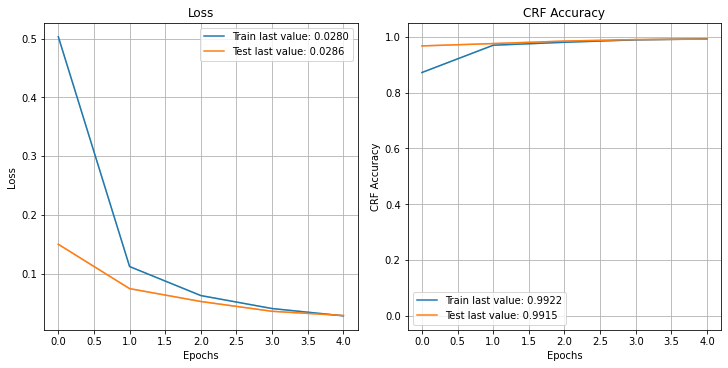

In [26]:
plot_history(history.history)

In [27]:
y_pred = ner_model.predict(X_test)
y_pred = np.argmax(y_pred, axis=2)
y_test = np.argmax(y_test, axis=2)
accuracy = (y_pred == y_test).mean()
print("Accuracy: {:.4f}/".format(accuracy))

Accuracy: 0.9914/


In [31]:
test_text = "A Indian, in America, in year 2021 attending Spring classes on Wednesday"

In [32]:
re_tok = re.compile(f"([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])")
test_text = re_tok.sub(r"  ", test_text).split()

padded_test_text = test_text + [word2index["--PADDING--"]] * (MAX_SENTENCE - len(test_text))
padded_test_text = [word2index.get(w, 0) for w in padded_test_text]

pred = ner_model.predict(np.array([padded_test_text]))
pred = np.argmax(pred, axis=-1)

retval = ""
for w, p in zip(test_text, pred[0]):
    print(w, index2tag[p])
    # retval = retval + "{:15}: {:5}".format(w, index2tag[p])

A O
Indian B-gpe
in O
America B-geo
in O
year O
2021 O
attending O
Spring O
classes O
on O
Wednesday B-tim
